In [69]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset

In [80]:
weather_data = pd.read_csv('/Users/llukii/Downloads/seattle-weather.csv')
weather_data.set_index('date', inplace=True)
weather_data.drop('weather', axis=1, inplace=True)
weather_data

,precipitation,temp_max,temp_min,wind
date,,,,
2012-01-01,0.0,12.8,5.0,4.7
2012-01-02,10.9,10.6,2.8,4.5
2012-01-03,0.8,11.7,7.2,2.3
2012-01-04,20.3,12.2,5.6,4.7
2012-01-05,1.3,8.9,2.8,6.1
...,...,...,...,...
2015-12-27,8.6,4.4,1.7,2.9
2015-12-28,1.5,5.0,1.7,1.3
2015-12-29,0.0,7.2,0.6,2.6


In [5]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [6]:
weather_data.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


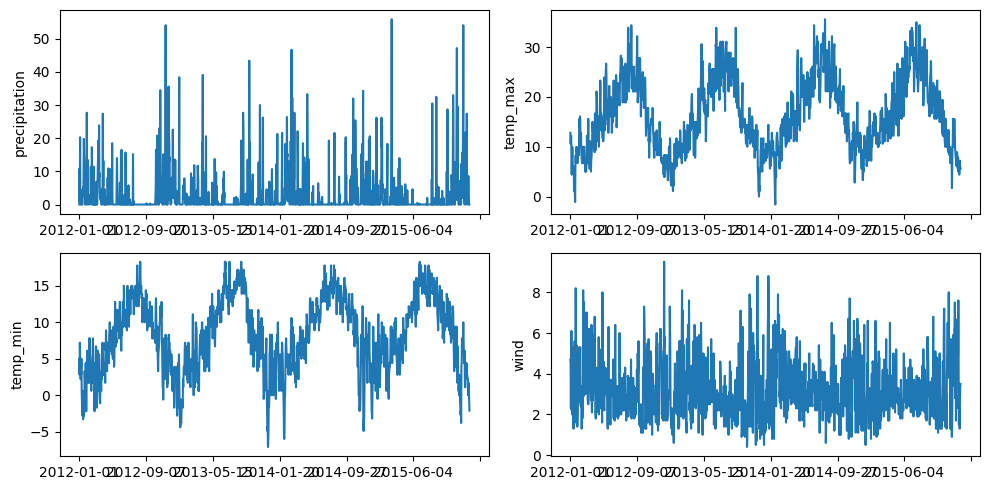

In [89]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
for i, col in enumerate(weather_data.columns):
    if i == 4: break
    plt.subplot(2, 2, i+1)
    weather_data[col].plot()
    plt.xlabel(None)
    plt.ylabel(col)

fig.tight_layout()

In [89]:
# consider weather from the last two weeks
scalar = MinMaxScaler()
scalar.fit(weather_data)
weather_normalized = scalar.transform(weather_data)
sequence_length = 28

pred_x, pred_y = [], []
for idx in range(sequence_length, weather_data.shape[0]):
    # Temperature minimum
    pred_x.append(weather_normalized[idx-sequence_length:idx, 2])
    pred_y.append(weather_data.iloc[idx, 2])

pred_x = np.array(pred_x, dtype=np.float32).reshape(-1, sequence_length, 1)
pred_y = np.array(pred_y, dtype=np.float32)
train_size = int(math.ceil(pred_x.shape[0] * 0.8))
test_x, test_y = pred_x[train_size:], pred_y[train_size:]
train_x, train_y = pred_x[:train_size], pred_y[:train_size]

In [90]:
batch_size = 64
class Weather(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

train_loader = DataLoader(Weather(train_x, train_y), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Weather(test_x, test_y), batch_size=batch_size, shuffle=True)
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
# N.B. use cuda if you're running this on google colab, kaggle, or your own device with an NVIDIA GPU.
# Probably not ideal for larger projects but this worked fine on my 16-core M1 Pro MBP

device

device(type='mps')

## Neural Network
RNN

In [91]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=256,
            batch_first=True,
        )
        self.dropout = nn.Dropout(p=0.2)
        self.batch_norm = nn.BatchNorm1d(256)
        self.fc = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        _, (x, _) = self.lstm(x)
        x = self.dropout(x)
        x = torch.flatten(x, start_dim=0, end_dim=1)
        x = self.batch_norm(x)
        x = self.fc(x)
        return x

In [92]:
model = NeuralNet().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
num_epochs = 60

## Train Model

In [94]:
loss_graph = []

def test(dataloader):
    model.eval()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred.reshape(-1), y)
        loss_graph.append(loss.item())


def train_epoch():
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        pred = model(x)
        loss = loss_fn(pred.reshape(-1), y)
        loss.backward()
        opt.step()

    test(test_loader)
    print(f"MSE Loss: {loss_graph[-1]}")

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_epoch()

Epoch 1/60
MSE Loss: 85.63795471191406
Epoch 2/60
MSE Loss: 17.963476181030273
Epoch 3/60
MSE Loss: 11.804671287536621
Epoch 4/60
MSE Loss: 13.960335731506348
Epoch 5/60
MSE Loss: 19.054317474365234
Epoch 6/60
MSE Loss: 13.912802696228027
Epoch 7/60
MSE Loss: 5.958886623382568
Epoch 8/60
MSE Loss: 21.91388702392578
Epoch 9/60
MSE Loss: 36.63014221191406
Epoch 10/60
MSE Loss: 12.737154006958008
Epoch 11/60
MSE Loss: 8.313924789428711
Epoch 12/60
MSE Loss: 28.826406478881836
Epoch 13/60
MSE Loss: 15.615570068359375
Epoch 14/60
MSE Loss: 3.583094596862793
Epoch 15/60
MSE Loss: 4.7187652587890625
Epoch 16/60
MSE Loss: 3.399152994155884
Epoch 17/60
MSE Loss: 4.683060646057129
Epoch 18/60
MSE Loss: 8.814945220947266
Epoch 19/60
MSE Loss: 2.9559438228607178
Epoch 20/60
MSE Loss: 7.623614311218262
Epoch 21/60
MSE Loss: 3.3880698680877686
Epoch 22/60
MSE Loss: 6.493316650390625
Epoch 23/60
MSE Loss: 5.39720344543457
Epoch 24/60
MSE Loss: 4.4886474609375
Epoch 25/60
MSE Loss: 2.6437389850616455


Text(0, 0.5, 'Loss')

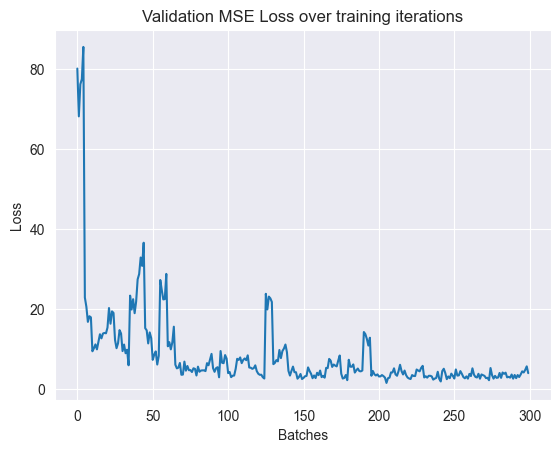

In [95]:
sns.lineplot(loss_graph)
plt.title("Validation MSE Loss over training iterations")
plt.xlabel("Batches")
plt.ylabel("Loss")

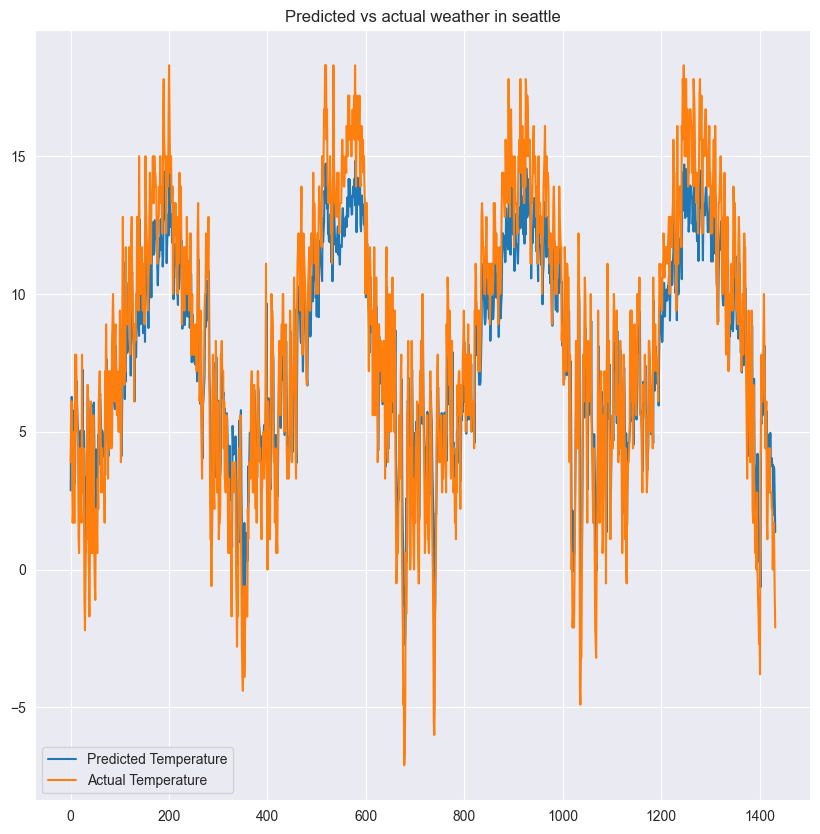

In [130]:
model_pred = model(torch.tensor(pred_x, dtype=torch.float32).reshape(-1, sequence_length, 1).to(device))
model_pred = model_pred.detach().cpu().numpy()

plt.figure(figsize=(10, 10))
plt.title("Predicted vs actual weather in seattle")
plt.plot(model_pred, label="Predicted Temperature");
plt.plot(pred_y, label="Actual Temperature")
plt.legend()

## Predict future temperature